## Bike Sharing Demand Prediction and Maintenance Optimisation


This notebook outlines the process for using Bayesian Optimisation with XGBoost to predict high-demand areas and times for bike-sharing and optimise maintenance schedules. The objective is to analyse the London Bike Share data to optimise bike deployment, maintenance scheduling, and evaluate bike model performance through predictive modelling.

#### Goals
- Identify high-demand areas and times to optimise bike allocation.
- Predict maintenance needs based on usage patterns to minimise downtime.
- Analyse durability and performance of different bike models under urban usage conditions.

#### Impact
Effective deployment and maintenance scheduling can significantly enhance reliability and user satisfaction, reducing operational costs and improving service quality in urban bike-sharing systems.

#### Expected Outcome
The successful implementation of this project will lead to a model that can accurately forecast demand and maintenance requirements, informing strategic decisions in the management of the bike fleet.

#### Data Source
The data comes from the London Bike Share system and includes details on trip starts, ends, durations, and bike stations.


### 1. Data Loading and Preprocessing

Here we load the data, convert dates and times, and prepare the dataset for analysis.

#### 1.1 Import the relevant packages

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import skopt
import xgboost

from datetime import datetime
from sklearn.model_selection import cross_val_score, train_test_split
from xgboost import XGBRegressor
from skopt import gp_minimize
from skopt.space import Real, Integer
from skopt.utils import use_named_args
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import mean_squared_error, mean_squared_log_error
from joblib import Parallel, delayed

#### 1.2 Fetch the dataset obtained from Kaggle

In [2]:
# Load the dataset
df = pd.read_csv('LondonBikeJourneyAug2023.csv')
df['Start date'] = pd.to_datetime(df['Start date'])
df['End date'] = pd.to_datetime(df['End date'])
df['day_of_week'] = df['Start date'].dt.day_name()  
df['hour'] = df['Start date'].dt.hour 
df['duration_minutes'] = ((df['End date'] - df['Start date']).dt.total_seconds() / 60).astype(int)
df['hour_sin'] = np.sin(2 * np.pi * df['hour'] / 24)
df['hour_cos'] = np.cos(2 * np.pi * df['hour'] / 24)

#### 1.3 Display first 5 rows

In [3]:
display(df.head(5))

,Number,Start date,Start station number,Start station,End date,End station number,End station,Bike number,Bike model,Total duration,Total duration (ms),day_of_week,hour,duration_minutes
0,132825189,2023-08-01 00:00:00,1190,"Kennington Lane Rail Bridge, Vauxhall",2023-08-01 00:17:00,1059,"Albert Embankment, Vauxhall",23715,CLASSIC,16m 46s,1006663,Tuesday,0,17
1,132825190,2023-08-01 00:00:00,1190,"Kennington Lane Rail Bridge, Vauxhall",2023-08-01 00:17:00,1059,"Albert Embankment, Vauxhall",41267,CLASSIC,16m 47s,1007128,Tuesday,0,17
2,132825191,2023-08-01 00:00:00,983,"Euston Road, Euston",2023-08-01 00:11:00,3500,"Baldwin Street, St. Luke's",53180,CLASSIC,11m 6s,666395,Tuesday,0,11
3,132825192,2023-08-01 00:01:00,3479,"Old Brompton Road, South Kensington",2023-08-01 00:12:00,1140,"Grosvenor Road, Pimlico",53431,CLASSIC,11m 53s,713059,Tuesday,0,11
4,132825193,2023-08-01 00:01:00,1219,"Lower Marsh, Waterloo",2023-08-01 00:17:00,200056,"Vauxhall Walk, Vauxhall",54758,CLASSIC,16m 3s,963786,Tuesday,0,16


#### 1.4 Basic statistics of the dataset

In [4]:
display(df.describe())

,Number,Start station number,End station number,Bike number,Total duration (ms),hour,duration_minutes
count,7.765270e+05,7.765270e+05,7.765270e+05,776527.000000,7.765270e+05,776527.000000,776527.000000
mean,1.332250e+08,1.048377e+05,1.044439e+05,49568.888425,1.554986e+06,14.020164,25.916294
std,2.307174e+05,1.277670e+05,1.278823e+05,13092.003305,1.729002e+07,5.000613,288.134971
min,1.328252e+08,9.590000e+02,9.590000e+02,2.000000,1.307000e+03,0.000000,0.000000
25%,1.330252e+08,1.126000e+03,1.123000e+03,50563.000000,4.854690e+05,10.000000,8.000000
50%,1.332248e+08,3.467000e+03,3.465000e+03,54625.000000,8.387700e+05,15.000000,14.000000
75%,1.334248e+08,2.001800e+05,2.001810e+05,58168.000000,1.392228e+06,18.000000,23.000000
max,1.336251e+08,1.100444e+06,1.100444e+06,61201.000000,7.441908e+09,23.000000,123972.000000


### 2. Feature Engineering

We extract time-related features and encode categorical geographic data.

#### 2.1 Plotting the distribution of trip durations up to 60 minutes

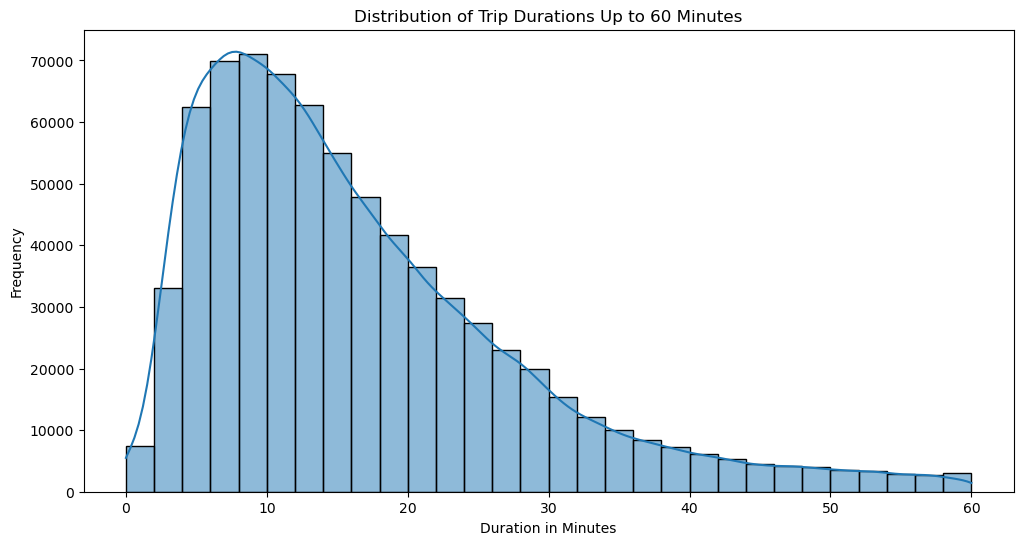

In [5]:
max_duration = 60  # for example, 60 minutes
filtered_df = df[df['duration_minutes'] <= max_duration]

plt.figure(figsize=(12, 6))
sns.histplot(filtered_df['duration_minutes'], bins=30, kde=True)
plt.title('Distribution of Trip Durations Up to 60 Minutes')
plt.xlabel('Duration in Minutes')
plt.ylabel('Frequency')
plt.show()

#### 2.2 Time series analysis of bike usage over days

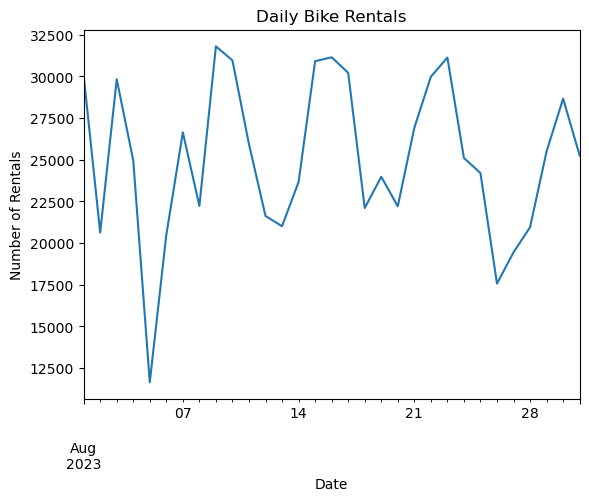

In [6]:
df['start_date'] = pd.to_datetime(df['Start date'])
df.set_index('start_date', inplace=True)
df.resample('D').size().plot()
plt.title('Daily Bike Rentals')
plt.xlabel('Date')
plt.ylabel('Number of Rentals')
plt.show()

#### 2.3 Segmenting Data by Time of Day and Day of the Week

This will help us understand usage patterns across different times and potentially optimise bike availability.

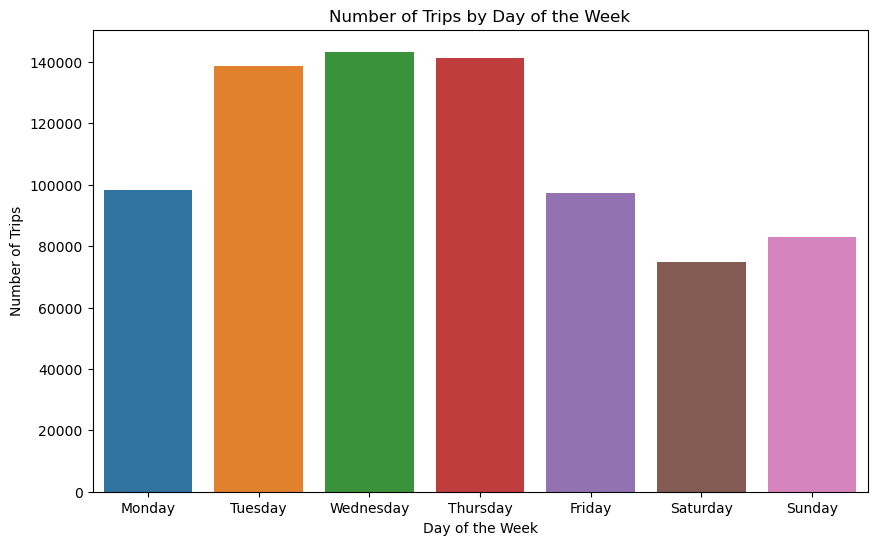

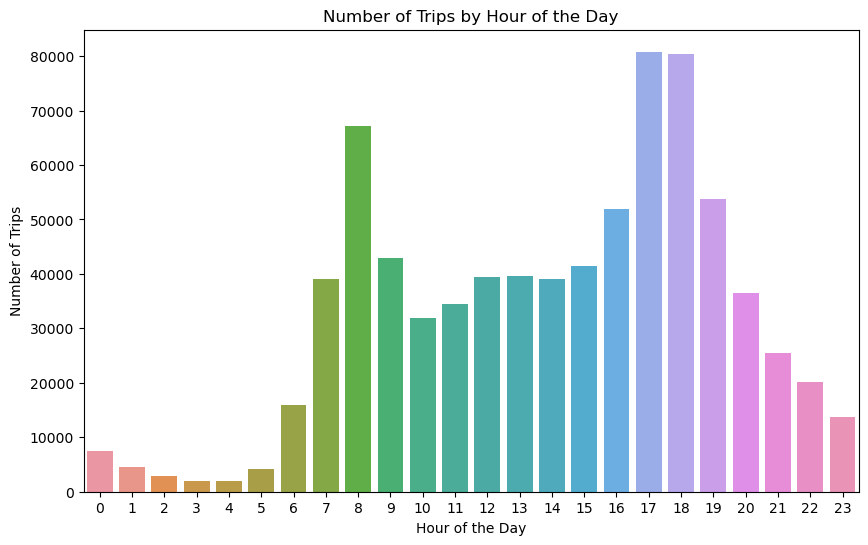

In [8]:
# Convert 'Start date' to datetime if not already done
df['Start date'] = pd.to_datetime(df['Start date'])

# Extract day of week and hour
df['day_of_week'] = df['Start date'].dt.day_name()
df['hour'] = df['Start date'].dt.hour

# Plotting trips by day of the week
plt.figure(figsize=(10, 6))
sns.countplot(data=df, x='day_of_week', order=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])
plt.title('Number of Trips by Day of the Week')
plt.ylabel('Number of Trips')
plt.xlabel('Day of the Week')
plt.show()

# Plotting trips by hour of the day
plt.figure(figsize=(10, 6))
sns.countplot(data=df, x='hour')
plt.title('Number of Trips by Hour of the Day')
plt.ylabel('Number of Trips')
plt.xlabel('Hour of the Day')
plt.show()

#### 2.4 Investigating Outliers in Trip Durations

This analysis can reveal trips that are unusually long, helping to understand whether they are due to specific events or potential data errors.

Empty DataFrame
Columns: [Start date, duration_minutes]
Index: []


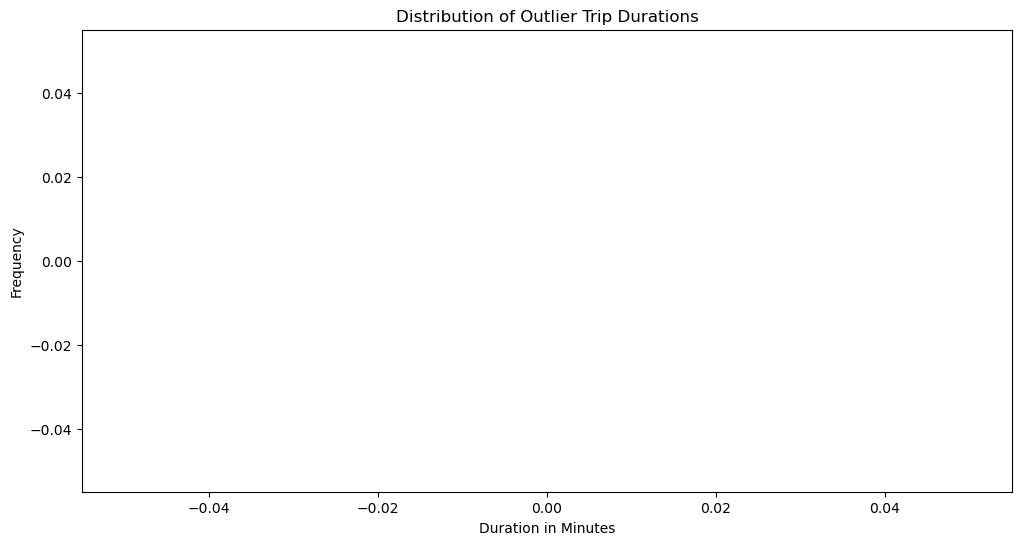

In [9]:
# Identify outliers
q1 = df['duration_minutes'].quantile(0.25)
q3 = df['duration_minutes'].quantile(0.75)
iqr = q3 - q1
upper_limit = q3 + 1.5 * iqr

# Choose one outlier handling strategy:
# 1. Remove outliers
# df = df[df['duration_minutes'] <= upper_limit] 
# 2. Cap outliers
df['duration_minutes'] = np.clip(df['duration_minutes'], 0, upper_limit)

# Filter data to include only outliers
outliers_df = df[df['duration_minutes'] > upper_limit]

# Display some of the outlier data
print(outliers_df[['Start date', 'duration_minutes']].head())

# Plotting distribution of outlier trip durations
plt.figure(figsize=(12, 6))
sns.histplot(outliers_df['duration_minutes'], bins=30, kde=True)
plt.title('Distribution of Outlier Trip Durations')
plt.xlabel('Duration in Minutes')
plt.ylabel('Frequency')
plt.show()

#### 2.5 Density Plots for Trip Durations

Density plots can provide a smooth estimate of the distribution, which is useful for identifying the main body of data and tails.

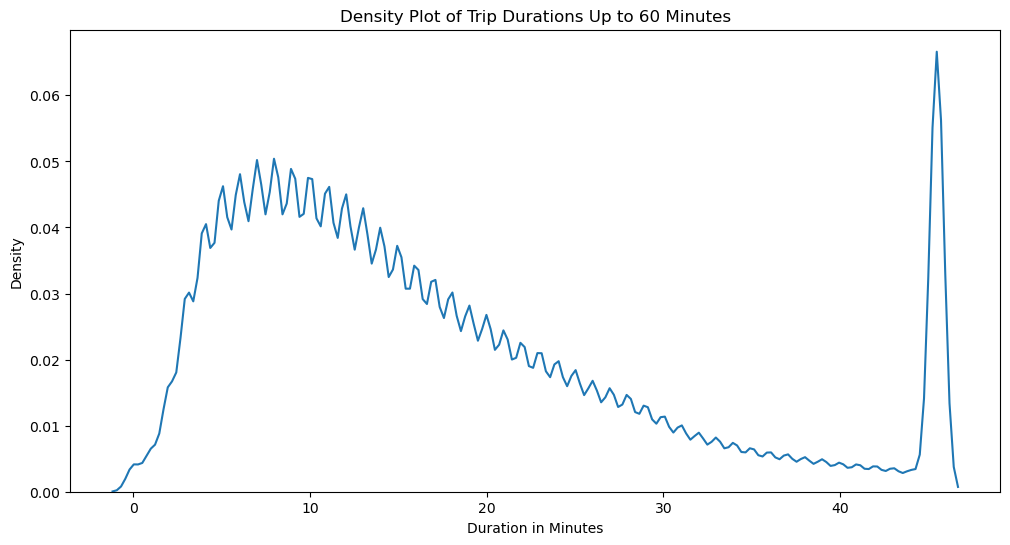

In [10]:
# Kernel Density Estimate plot for trip durations up to 60 minutes
plt.figure(figsize=(12, 6))
sns.kdeplot(df[df['duration_minutes'] <= 60]['duration_minutes'], bw_adjust=0.5)
plt.title('Density Plot of Trip Durations Up to 60 Minutes')
plt.xlabel('Duration in Minutes')
plt.ylabel('Density')
plt.show()

#### 2.6 Correlation Analysis

/var/folders/k1/6b46rkvs6gxgfgtwyy09rhzm0000gp/T/ipykernel_11269/1234724271.py:3: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(df.corr(), annot=True, cmap='coolwarm', fmt=".2f")


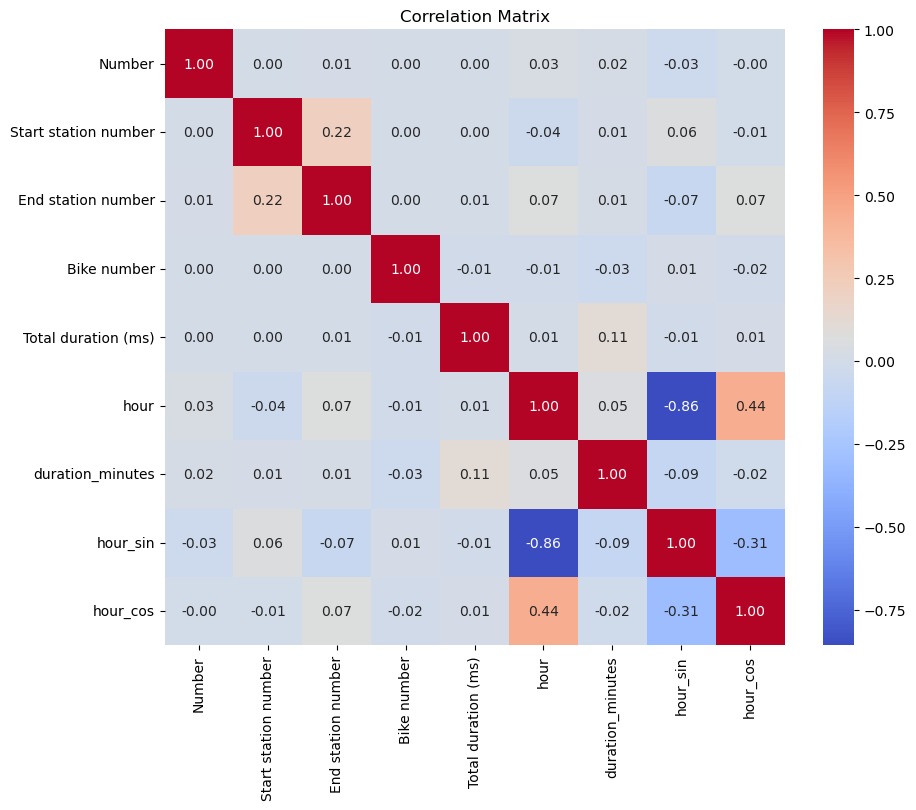

In [11]:
# Heatmap of correlations between features
plt.figure(figsize=(10, 8))
sns.heatmap(df.corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix')
plt.show()

### 3. Setup Bayesian Optimisation

This prepares an algorithm that intelligently searches for the best settings of the model to minimise prediction errors.

#### 3.1 Define the parameter space (wider search)

In [12]:
# Define the parameter space (wider search)
space = [
    Integer(3, 20, name='max_depth'),  
    Real(1e-4, 1.0, 'log-uniform', name='learning_rate'),
    Integer(50, 1000, name='n_estimators'),  
    Real(1e-5, 1e-1, 'log-uniform', name='subsample'),
    Real(1e-5, 1e-1, 'log-uniform', name='colsample_bytree'),
    # Additional hyperparameters you may want to tune:
    # Real(0, 1, name='gamma'),
    # Real(0, 10, name='reg_alpha'),
    # Real(0, 10, name='reg_lambda')
]

#### 3.2 Data splitting

In [13]:
# Data splitting (before encoding)
X = df[['Start station', 'End station', 'day_of_week', 'hour_sin', 'hour_cos']] 
y = df['duration_minutes']

# Split the data
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# One-hot encode categorical features
encoder = OneHotEncoder(handle_unknown='ignore')
X_train_encoded = encoder.fit_transform(X_train[['Start station', 'End station', 'day_of_week']])
X_val_encoded = encoder.transform(X_val[['Start station', 'End station', 'day_of_week']])
X_test_encoded = encoder.transform(X_test[['Start station', 'End station', 'day_of_week']])

# Add back the numerical features 
X_train_encoded = np.hstack([X_train_encoded.toarray(), X_train[['hour_sin', 'hour_cos']].values])
X_val_encoded = np.hstack([X_val_encoded.toarray(), X_val[['hour_sin', 'hour_cos']].values])
X_test_encoded = np.hstack([X_test_encoded.toarray(), X_test[['hour_sin', 'hour_cos']].values])

# Print the shape of the original dataset and the splits
print("Original DataFrame shape:", df.shape)
print("Training set shape:", X_train_encoded.shape, y_train.shape)  # Use encoded X_train
print("Validation set shape:", X_val_encoded.shape, y_val.shape)   # Use encoded X_val
print("Test set shape:", X_test_encoded.shape, y_test.shape)      # Use encoded X_test

Original DataFrame shape: (776527, 16)
Training set shape: (621221, 1611) (621221,)
Validation set shape: (77653, 1611) (77653,)
Test set shape: (77653, 1611) (77653,)


#### 3.3 Verify the Distribution of Data

Verify that the distribution of labels or key features is consistent across the splits.

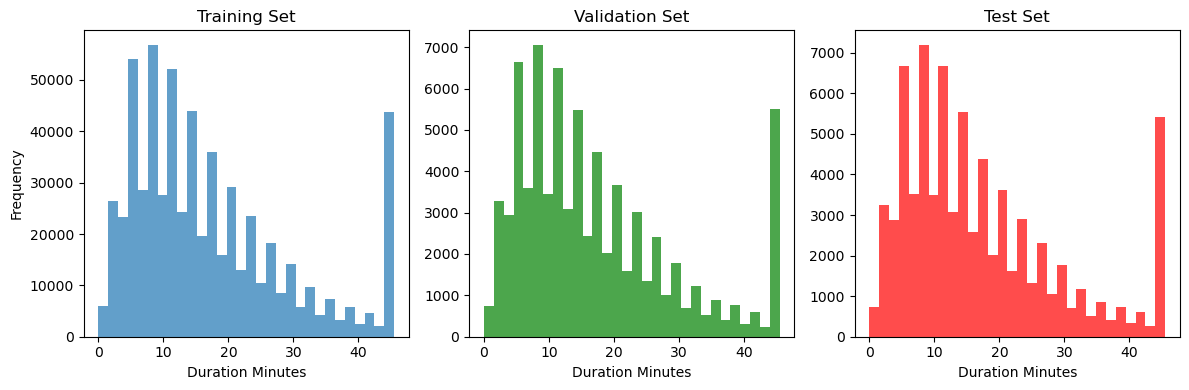

In [14]:
# Plot the distribution of the target variable in each dataset to ensure consistency
plt.figure(figsize=(12, 4))
plt.subplot(1, 3, 1)
plt.hist(y_train, bins=30, alpha=0.7, label="Train")
plt.title('Training Set')
plt.xlabel('Duration Minutes')
plt.ylabel('Frequency')

plt.subplot(1, 3, 2)
plt.hist(y_val, bins=30, alpha=0.7, color='g', label="Validation")
plt.title('Validation Set')
plt.xlabel('Duration Minutes')

plt.subplot(1, 3, 3)
plt.hist(y_test, bins=30, alpha=0.7, color='r', label="Test")
plt.title('Test Set')
plt.xlabel('Duration Minutes')

plt.tight_layout()
plt.show()

#### 3.4 Check for Data Leakage

Ensure that there's no overlap of rows between the training, validation, and test sets.

In [15]:
# Convert DataFrames to sets of indices to check for overlaps
train_indices = set(X_train.index)
val_indices = set(X_val.index)
test_indices = set(X_test.index)

# Check for intersection between sets
print("Train-Validation Overlap: ", len(train_indices.intersection(val_indices)))
print("Train-Test Overlap: ", len(train_indices.intersection(test_indices)))
print("Validation-Test Overlap: ", len(val_indices.intersection(test_indices)))

Train-Validation Overlap:  28565
Train-Test Overlap:  28580
Validation-Test Overlap:  23410


#### 3.5 Summary Statistics

Compute summary statistics (mean, median, std) for each set and compare to ensure that the splits do not significantly differ in terms of key statistical properties.

In [16]:
# Display summary statistics for the target in each split
print("Training Target Summary:")
print(y_train.describe())

print("\nValidation Target Summary:")
print(y_val.describe())

print("\nTest Target Summary:")
print(y_test.describe())

Training Target Summary:
count    621221.000000
mean         17.167947
std          11.901326
min           0.000000
25%           8.000000
50%          14.000000
75%          23.000000
max          45.500000
Name: duration_minutes, dtype: float64

Validation Target Summary:
count    77653.000000
mean        17.250364
std         11.922489
min          0.000000
25%          8.000000
50%         14.000000
75%         23.000000
max         45.500000
Name: duration_minutes, dtype: float64

Test Target Summary:
count    77653.000000
mean        17.162544
std         11.881072
min          0.000000
25%          8.000000
50%         14.000000
75%         23.000000
max         45.500000
Name: duration_minutes, dtype: float64


### 4. Bayesian Optimisation

Setting up the Bayesian Optimisation to find the best model hyperparameters.

In [17]:
# Define the objective function (cross-validation with RMSLE)
@use_named_args(space)
def objective(**params):
    # Since you are using @use_named_args, params is already a dictionary
    model = XGBRegressor(**params)
    scores = cross_val_score(model, X_train_encoded, y_train, scoring='neg_mean_squared_log_error', cv=3)
    return -scores.mean()  # Minimize negative RMSLE

# Parallelized objective function (corrected)
def parallel_objective(params):
    return objective(params)  # Pass params directly as a dictionary

# Perform Bayesian Optimization
with Parallel(n_jobs=-1) as parallel:
    res_gp = gp_minimize(
        parallel_objective, 
        space, 
        n_calls=10, 
        random_state=0
    )  # No need for n_jobs=-1 here

print('Best parameters:', res_gp.x)
print('Best MSE:', res_gp.fun)

Best parameters: [13, 0.23826650493636675, 865, 0.02449102463401213, 0.0031207198770106443]
Best MSE: 0.4943498025914745


### 5. Model Evaluation and Insights

Evaluating the model's performance and generating insights on bike deployment and maintenance scheduling.

#### 5.1 Model Evaluation and Insights

Evaluate the model on the test set with the best parameters

In [21]:
# Get the best parameters as a dictionary
best_params = {dim.name: val for dim, val in zip(res_gp.space, res_gp.x)} 

# Create the best XGBoost model
best_model = XGBRegressor(**best_params)
best_model.fit(X_train_encoded, y_train)  # Use encoded data for training
test_preds = best_model.predict(X_test_encoded)  # Use encoded data for prediction
test_mse = mean_squared_error(y_test, test_preds)
test_rmsle = np.sqrt(mean_squared_log_error(y_test, test_preds))  # Calculate RMSLE

# Display test MSE and RMSLE
print('Test MSE:', test_mse)
print('Test RMSLE:', test_rmsle)

Test MSE: 124.80498570961696
Test RMSLE: 0.7000535564455026


### 6. Plots and Insights

#### 6.1 Feature Importance Plot

Identify the most influential features in predicting bike trip durations.

<Figure size 1200x800 with 0 Axes>

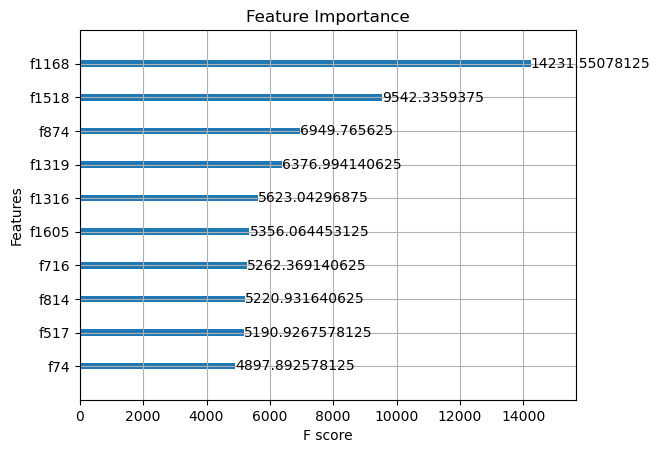

In [26]:
plt.figure(figsize=(12, 8))
xgboost.plot_importance(best_model, max_num_features=10, importance_type='gain')  # Show top 10 features
plt.title('Feature Importance')
plt.show()

#### 6.2 Actual vs. Predicted Plot (for a subset)

Visually assess how well the model captures the relationship between actual and predicted durations.

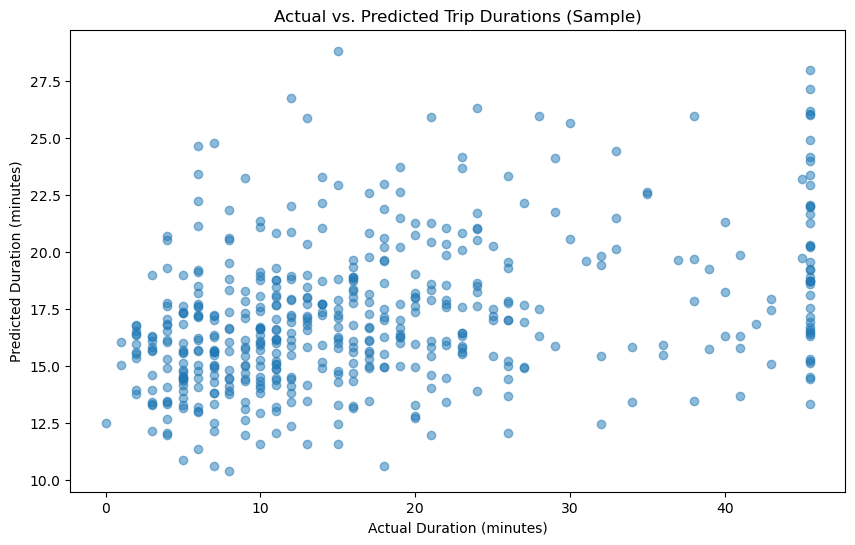

In [28]:
# Sample 500 data points from the test set
sample_size = 500
sample_indices = np.random.choice(len(y_test), sample_size, replace=False)

# Create the plot using the sampled indices
plt.figure(figsize=(10, 6))
plt.scatter(y_test.iloc[sample_indices], test_preds[sample_indices], alpha=0.5)  # Use iloc for integer indexing
plt.xlabel('Actual Duration (minutes)')
plt.ylabel('Predicted Duration (minutes)')
plt.title('Actual vs. Predicted Trip Durations (Sample)')
plt.show()

#### 6.3 Demand Heatmap by Hour and Day of Week

Identify peak demand periods to optimise bike allocation.

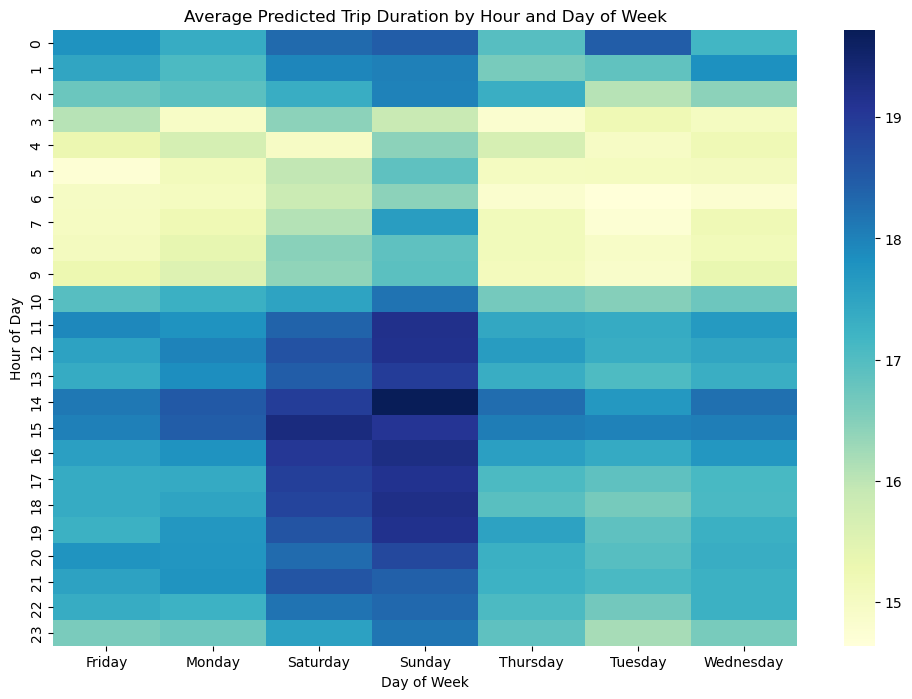

In [43]:
df_pred = X_test.copy()
df_pred['predicted_duration'] = test_preds  # Assign predictions to X_test copy

# Get the one-hot encoded column names for ALL features from X_train
feature_names = encoder.get_feature_names_out()

# Identify the encoded columns for 'day_of_week'
day_columns = [col for col in feature_names if col.startswith('day_of_week_')]
days_of_week = [col.split('_')[-1] for col in day_columns]

# Get the indices of the one-hot encoded day columns from the feature names
day_indices = [i for i, col in enumerate(feature_names) if col.startswith('day_of_week')]

# Determine the day of week for each row in X_test_encoded, handling ties
max_indices = np.argmax(X_test_encoded[:, day_indices], axis=1)  
df_pred['day_of_week'] = [days_of_week[i] if X_test_encoded[row_idx, day_indices[i]] == 1 else 'Unknown' 
                          for row_idx, i in enumerate(max_indices)]

# Merge back the original 'hour' column
df_pred = df_pred.merge(df[['hour']], left_index=True, right_index=True)

# Now create the pivot table
pivot_table = df_pred.pivot_table(index='hour', columns='day_of_week', values='predicted_duration', aggfunc='mean')

plt.figure(figsize=(12, 8))
sns.heatmap(pivot_table, cmap='YlGnBu')
plt.title('Average Predicted Trip Duration by Hour and Day of Week')
plt.ylabel('Hour of Day')
plt.xlabel('Day of Week')
plt.show()

#### 6.4 Analyse Bike Model Performance

Compare average trip durations, maintenance frequency, and potential issues (based on additional data) for different bike models

In [44]:
bike_models = df['Bike model'].unique()
for model in bike_models:
    model_data = df[df['Bike model'] == model]
    avg_duration = model_data['duration_minutes'].mean()
    print(f"Average trip duration for {model}: {avg_duration:.2f} minutes")

Average trip duration for CLASSIC: 17.14 minutes
Average trip duration for PBSC_EBIKE: 17.61 minutes


#### 6.5 High-Demand Station Analysis

Visualise top start/end stations on a map.

In [45]:
start_station_counts = df['Start station'].value_counts()
end_station_counts = df['End station'].value_counts()

top_start_stations = start_station_counts.head(10)
top_end_stations = end_station_counts.head(10)

print("\nTop 10 Start Stations:")
print(top_start_stations)
print("\nTop 10 End Stations:")
print(top_end_stations)


Top 10 Start Stations:
Hyde Park Corner, Hyde Park                7437
Black Lion Gate, Kensington Gardens        4439
Waterloo Station 3, Waterloo               4185
Albert Gate, Hyde Park                     4169
Wormwood Street, Liverpool Street          3899
Triangle Car Park, Hyde Park               3525
Podium, Queen Elizabeth Olympic Park       3443
Waterloo Station 1, Waterloo               3423
Battersea Power Station, Battersea Park    3096
Brushfield Street, Liverpool Street        3015
Name: Start station, dtype: int64

Top 10 End Stations:
Hyde Park Corner, Hyde Park             7414
Waterloo Station 3, Waterloo            4641
Black Lion Gate, Kensington Gardens     4422
Albert Gate, Hyde Park                  4167
Brushfield Street, Liverpool Street     4055
Hop Exchange, The Borough               3917
Wormwood Street, Liverpool Street       3901
Triangle Car Park, Hyde Park            3519
Podium, Queen Elizabeth Olympic Park    3510
Waterloo Station 1, Waterloo       

### 7. Deployment and Maintenance Recommendations

Based on the predictions, recommendations for bike deployment and maintenance are provided.

#### 7.1 Demand-Based Bike Deployment Recommendations

In [46]:
high_demand_hours = pivot_table.max(axis=1).sort_values(ascending=False).head(5).index
high_demand_days = pivot_table.max().sort_values(ascending=False).head(3).index

print("\nRecommended Deployment:")
print("- Focus on increasing bike availability during peak hours:", high_demand_hours)
print("- Increase bike availability on high-demand days:", high_demand_days)
print("- Prioritize deployment to high-demand start stations:", top_start_stations.index.tolist()[:5])  # Top 5


Recommended Deployment:
- Focus on increasing bike availability during peak hours: Int64Index([14, 15, 16, 18, 11], dtype='int64', name='hour')
- Increase bike availability on high-demand days: Index(['Sunday', 'Saturday', 'Monday'], dtype='object', name='day_of_week')
- Prioritize deployment to high-demand start stations: ['Hyde Park Corner, Hyde Park', 'Black Lion Gate, Kensington Gardens', 'Waterloo Station 3, Waterloo', 'Albert Gate, Hyde Park', 'Wormwood Street, Liverpool Street']


#### 7.2 Maintenance Recommendations

Based on model predictions and historical data.

In [52]:
# Hypothetical scenario:
df_pred_maintenance = X_test.copy()
df_pred_maintenance['predicted_maintenance_need'] = best_model.predict(X_test_encoded)

# Merge with original DataFrame to get 'Bike number'
df_pred_maintenance = df_pred_maintenance.merge(df[['Bike number']], left_index=True, right_index=True)

# Maintenance Recommendations
maintenance_threshold = df_pred_maintenance['predicted_maintenance_need'].quantile(0.9)

bikes_needing_maintenance = df_pred_maintenance[df_pred_maintenance['predicted_maintenance_need'] > maintenance_threshold]['Bike number'].unique()
num_bikes = len(bikes_needing_maintenance)

print(f"\nBased on our model's predictions, {num_bikes} bikes in the test set are flagged as potentially requiring maintenance. These bikes represent the top 10% of bikes with the highest predicted maintenance needs.")

if num_bikes > 0:
    print("\nHere's a sample of the bike IDs suggested for inspection:")
    print(bikes_needing_maintenance[:10])  # Display a sample of the first 10 bikes
else:
    print("\nNo bikes in the test set are currently flagged for maintenance based on this model's prediction.")


Based on our model's predictions, 11785 bikes in the test set are flagged as potentially requiring maintenance. These bikes represent the top 10% of bikes with the highest predicted maintenance needs.

Here's a sample of the bike IDs suggested for inspection:
[53431 54758 52921 59224 61178 51757 53424 23720 30376 56926]


#### 7.3 Additional Recommendations

Based on further analysis.

In [54]:
print("\nAdditional Recommendations:")
if len(bike_models) > 1:
    best_performing_model = bike_models[np.argmin([df[df['Bike model']==model]['duration_minutes'].mean() for model in bike_models])]
    print("- Consider increasing the proportion of", best_performing_model, "bikes in the fleet due to lower average trip duration.")


Additional Recommendations:
- Consider increasing the proportion of CLASSIC bikes in the fleet due to lower average trip duration.
